# Skills challenge \#9
Below are a series of questions. Use the loaded data to answer the questions. You will almost certainly need to import more packages (`pandas`, `numpy`, etc.) to complete these. You are welcome to use any source except for your classmates. So Google away!

You will be graded on both the **correctness** and **cleanliness** of your work. So don't submit poorly written code or your grade will reflect that. Use Markdown describing what you have done. If you get stuck, move on to another part. Most questions don't rely on the answer to earlier questions.

### Imports

In [1]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Data loading

In [2]:
df = pd.read_csv('../../data/2016_austin_crime.csv')

In [3]:
df.head()

,GO Primary Key,Council District,GO Highest Offense Desc,Highest NIBRS/UCR Offense Description,GO Report Date,GO Location,Clearance Status,Clearance Date,GO District,GO Location Zip,GO Census Tract,GO X Coordinate,GO Y Coordinate
0,201610188.0,8.0,AGG ASLT ENHANC STRANGL/SUFFOC,Agg Assault,1-Jan-16,8600 W SH 71 ...,C,12-Jan-16,D,78735.0,19.08,3067322.0,10062796.0
1,201610643.0,9.0,THEFT,Theft,1-Jan-16,219 E 6TH ST ...,C,4-Jan-16,G,78701.0,11.00,3114957.0,10070462.0
2,201610892.0,4.0,AGG ROBBERY/DEADLY WEAPON,Robbery,1-Jan-16,701 W LONGSPUR BLVD ...,N,3-May-16,E,78753.0,18.23,3129181.0,10106923.0
3,201610893.0,9.0,THEFT,Theft,1-Jan-16,404 COLORADO ST ...,N,22-Jan-16,G,78701.0,11.00,3113643.0,10070357.0
4,201611018.0,4.0,SEXUAL ASSAULT W/ OBJECT,Rape,1-Jan-16,NaN,C,10-Mar-16,E,78753.0,18.33,NaN,NaN


### Data description

This data is all the crimes recorded by the Austin PD in 2016, which you used previously in skills challenge 1. The columns that we are interested are:
- **Council District**: The district in which the crime was committed ([map of districts](https://www.austinchronicle.com/binary/35e1/pols_feature51.jpg))
- **GO Highest Offense Desc**: A text description of the offense using the APD description
- **Highest NIBRS/UCR Offense Description**: A text description using the FBI description
- **GO Report Date**: The date on which the crime was reported
- **Clearance Status**: Whether or not the crime was "cleared" (i.e. the case was closed due to an arrest)
- **Clearance Date**: When the crime was cleared
- **GO Location Zip**: The zip code where the crime occurred

## Tasks

### Data cleaning
**DC1:** Drop all columns except those listed above. Also drop any rows with any missing values. Save the result back to `df`.

In [4]:
df = df[['Council District', 'Highest NIBRS/UCR Offense Description', 'GO Report Date', 'Clearance Status', 'Clearance Date', 'GO Location Zip']]
df = df.dropna(how='any')

**DC2:** Rename the columns to be all lowercase, replace spaces with underscores ("_"), and remove "GO" from all column names. Finally, make sure there are no spaces at the start or finish of a column name. For example, ``'  my_col '`` should be renamed to `'my_col'` (notice that the spaces are gone), and "GO Report Date" should become "report_date". Rename "Highest NIBRS/UCR Offense Description" to "fbi_desc".

In [5]:
clean_cols = [c if c != 'Highest NIBRS/UCR Offense Description' else 'fbi_desc' for c in df.columns]
clean_cols = [c if c != 'GO Highest Offense Desc' else 'apd_desc' for c in clean_cols]
clean_cols = [c.replace('GO', '').replace(' ', '_').lower().strip().strip('_') for c in clean_cols]
df.columns = clean_cols

**DC3:** Create four new columns: `report_month`, `report_day`, `clearance_month` and `clearance_day` (we don't need year, because they're all from 2016) using the report date  and clearance date columns, respectively. Make sure the values in `*_day` are integers, not strings (you can have strings for `*_month`). Once you are done, drop the report date and clearance date columns.

In [6]:
df['report_day'] = df['report_date'].apply(lambda x: x.split('-')[0])
df['report_month'] = df['report_date'].apply(lambda x: x.split('-')[1])

df['clearance_day'] = df['clearance_date'].apply(lambda x: x.split('-')[0])
df['clearance_month'] = df['clearance_date'].apply(lambda x: x.split('-')[1])

df['report_day'] = df['report_day'].astype(int)
df['clearance_day'] = df['clearance_day'].astype(int)

df = df.drop(['report_date', 'clearance_date'], axis='columns')

**DC4:** Label encode all of the categorical columns if they are not already integers. Save the label encoders into a dictionary where the key is the (cleaned) column name. So you should have a dictionary `label_encoders` which looks like `label_encoder['council_district'] = the label encoder for the council_district column`, and so forth.

In [7]:
df.dtypes

council_district    float64
fbi_desc             object
clearance_status     object
location_zip        float64
report_day            int64
report_month         object
clearance_day         int64
clearance_month      object
dtype: object

In [8]:
object_cols = ['fbi_desc', 'clearance_status', 'report_month', 'clearance_month']
label_encoders = {}

for c in object_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])
    label_encoders[c] = le

In [9]:
df.head()

,council_district,fbi_desc,clearance_status,location_zip,report_day,report_month,clearance_day,clearance_month
0,8.0,0,0,78735.0,1,4,12,4
1,9.0,6,0,78701.0,1,4,4,4
2,4.0,5,1,78753.0,1,4,3,8
3,9.0,6,1,78701.0,1,4,22,4
4,4.0,4,0,78753.0,1,4,10,7


### Model building

**MB1:** Split the data into training and testing sets. Your test set should have 20% of the data, and the training set should have the remaining 80%. Split the training and testing sets into X and y, where y is the clearance status.

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2)

X_cols = ['council_district', 'fbi_desc', 'location_zip', 'report_day', 'report_month', 'clearance_day', 'clearance_month']
y_col = 'clearance_status'

X_train = train_df[X_cols]
y_train = train_df[y_col]

X_test = test_df[X_cols]
y_test = test_df[y_col]

**MB2:** Train a decision tree classifier to predict the clearance status given all other columns. Set the `max_depth` to 3 and the `min_samples_split` to 5. Be sure to train on the training set only. 

In [11]:
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=5)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Model evaluation

**ME1:** Print a classification report to show the results. Be sure to make your predictions/do your evaluations on the test set only. Create a Markdown cell discussing what you found.

In [12]:
y_preds = dt_clf.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.48      0.20      0.28       968
           1       0.86      0.97      0.91      5948
           2       0.00      0.00      0.00       196

    accuracy                           0.84      7112
   macro avg       0.45      0.39      0.40      7112
weighted avg       0.79      0.84      0.80      7112



/Users/paulsavala/anaconda3/envs/math_3439/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model generally does a good job predicting cases with a clearance status of 1, and a poor job with clearance status of 0. Apparently, there are clearance status values of 2, and yet none were predicted.

In [13]:
y_test.value_counts()

1    5948
0     968
2     196
Name: clearance_status, dtype: int64

In [14]:
pd.Series(y_preds).value_counts()

1    6711
0     401
dtype: int64

**ME2:** Print a confusion matrix by following [the sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html). Set `values_format='d'` to show numbers and not scientific notation. Do this for the test set. Create a Markdown cell discussing what you see.

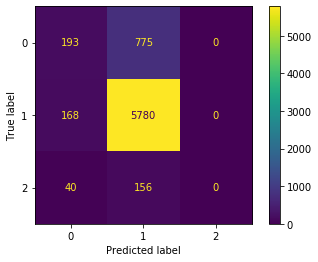

In [15]:
plot_confusion_matrix(dt_clf, X_test, y_test, values_format='d')

It seems that our model does a fairly good job with class 1, and poor with everything else. 

## Model tuning

**MT1:** Build decision tree classifiers with all possible combinations of the following values: `max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]`, `min_samples_split = [2, 5, 10, 15, 20]`. Do this using for loops. So you should have a model with (for example) `max_depth=2` and `min_samples_split=1`, and another with `max_depth=2` and `min_samples_split=5`, and so forth. This will result in 9 * 5 = 45 different decision tree models. Find which model has the best accuracy (hint: using the `.score()` method for a classification model will return the accuracy). Use the `.get_params()` method for the best decision tree to see what its depth and min samples split was.

In [16]:
# Use these to keep track of the best accuracy, along with which model achieved it
best_acc = 0
best_dt = None

for max_depth in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for min_samples_split in [2, 5, 10, 15, 20]:
        dt_clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        dt_clf.fit(X_train, y_train)
        acc = dt_clf.score(X_test, y_test)
        if acc > best_acc:
            best_acc = acc
            best_dt = dt_clf

In [17]:
print(f'Best accuracy = {100*best_acc:.2f}%')

Best accuracy = 84.24%


In [18]:
best_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

**MT2:** Use grid search cross validation to search the same hyperparameters as you did above. Show what the best hyperparameters it finds are.

In [20]:
dt_clf = DecisionTreeClassifier()

hyperparams_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5, 10, 15, 20]}

grid_search_clf = GridSearchCV(dt_clf, hyperparams_grid, n_jobs=-1)

grid_search_clf.fit(X_train, y_train)

grid_search_clf.best_params_

{'max_depth': 6, 'min_samples_split': 2}

### Bonus

**B1:** Try both under and oversampling the data to see if you can get a model which will actually predict any clearance status of 2. Compare the accuracy of it to what you got from other decision tree models.

In [89]:
train_df['clearance_status'].value_counts()

1    23677
0     3961
2      808
Name: clearance_status, dtype: int64

We'll start by undersampling so that all clearance status will have 808 samples (the smallest number). This will result in a much smaller training set, which may be problematic.

In [94]:
train_df_0 = train_df[train_df['clearance_status'] == 0]
train_df_1 = train_df[train_df['clearance_status'] == 1]
train_df_2 = train_df[train_df['clearance_status'] == 2]

train_df_under = pd.concat([train_df_0.sample(808), train_df_1.sample(808), train_df_2.sample(808)])

Let's just use the hyperparameters from the best model above to see how it works here. This will save us the time of doing a hyperparameter search.

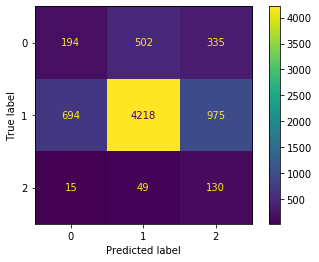

In [91]:
X_train_under = train_df_under[X_cols]
y_train_under = train_df_under[y_col]

dt_clf_under = DecisionTreeClassifier(max_depth=6, min_samples_split=2, min_samples_leaf=20)
dt_clf_under.fit(X_train_under, y_train_under)

plot_confusion_matrix(dt_clf_under, X_test, y_test, values_format='d')

It sure did predict all classes! Let's check the accuracy.

In [92]:
dt_clf_under.score(X_test, y_test)

0.6386389201349831

Pretty low compared to what we had before. Let's look at the classification report as well.

In [93]:
y_under_preds = dt_clf_under.predict(X_test)
print(classification_report(y_test, y_under_preds))

              precision    recall  f1-score   support

           0       0.21      0.19      0.20      1031
           1       0.88      0.72      0.79      5887
           2       0.09      0.67      0.16       194

    accuracy                           0.64      7112
   macro avg       0.40      0.52      0.38      7112
weighted avg       0.77      0.64      0.69      7112



So the performance on class 2 is still pretty poor, but at least it's showing up. Let's also try oversampling to see if the model is any better.

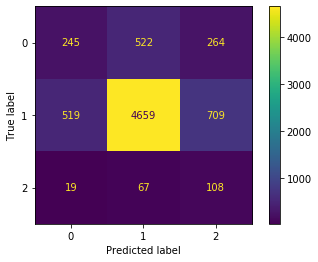

In [95]:
train_df_over = pd.concat([train_df_0.sample(23677, replace=True), train_df_1.sample(23677, replace=True), train_df_2.sample(23677, replace=True)])

X_train_over = train_df_over[X_cols]
y_train_over = train_df_over[y_col]

dt_clf_over = DecisionTreeClassifier(max_depth=6, min_samples_split=2, min_samples_leaf=20)
dt_clf_over.fit(X_train_over, y_train_over)

plot_confusion_matrix(dt_clf_over, X_test, y_test, values_format='d')

In [96]:
dt_clf_over.score(X_test, y_test)

0.7047244094488189

In [97]:
y_over_preds = dt_clf_over.predict(X_test)
print(classification_report(y_test, y_over_preds))

              precision    recall  f1-score   support

           0       0.31      0.24      0.27      1031
           1       0.89      0.79      0.84      5887
           2       0.10      0.56      0.17       194

    accuracy                           0.70      7112
   macro avg       0.43      0.53      0.43      7112
weighted avg       0.78      0.70      0.74      7112



Based on the f1-scores and the accuracy this seems to be a better model than the undersampled one. The accuracy is strictly worse than *all* of the models trained earlier on the original data. Therefore, if raw accuracy is our goal then the original models are best. However, if being able to predict all classes is important, then perhaps the oversampled model is best.